In [10]:
!pip -q install ultralytics scikit-learn

In [17]:

import os, shutil, json, math, glob, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from ultralytics import YOLO

In [13]:
SEED = 42
random.seed(SEED); np.random.seed(SEED)

print("Setup complete.")

Setup complete.


In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [14]:
from pathlib import Path

data_path = Path("/kaggle/input/gtsrb-german-traffic-sign")
for p in data_path.iterdir():
    print(" -", p)


 - /kaggle/input/gtsrb-german-traffic-sign/Meta
 - /kaggle/input/gtsrb-german-traffic-sign/meta
 - /kaggle/input/gtsrb-german-traffic-sign/Meta.csv
 - /kaggle/input/gtsrb-german-traffic-sign/Train.csv
 - /kaggle/input/gtsrb-german-traffic-sign/Test.csv
 - /kaggle/input/gtsrb-german-traffic-sign/Test
 - /kaggle/input/gtsrb-german-traffic-sign/test
 - /kaggle/input/gtsrb-german-traffic-sign/Train
 - /kaggle/input/gtsrb-german-traffic-sign/train


In [15]:
DATA_ROOT = Path("/kaggle/input/gtsrb-german-traffic-sign")
TRAIN_DIR = DATA_ROOT / "Train"
TEST_DIR  = DATA_ROOT / "Test"
TRAIN_CSV = DATA_ROOT / "Train.csv"
TEST_CSV  = DATA_ROOT / "Test.csv"

assert TRAIN_DIR.exists() and TEST_DIR.exists(), "Train/ and Test/ folders not found."
assert TRAIN_CSV.exists() and TEST_CSV.exists(), "Train.csv/Test.csv not found."

In [16]:
# Output (YOLOv8 classification layout)
OUT = Path("/content/gtsrb_yolo")
if OUT.exists(): shutil.rmtree(OUT)
for s in ["train","val","test"]:
    (OUT/s).mkdir(parents=True, exist_ok=True)

print("Input root:", DATA_ROOT)
print("Output root:", OUT)

Input root: /kaggle/input/gtsrb-german-traffic-sign
Output root: /content/gtsrb_yolo


In [17]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

In [18]:

# Clean column names and paths
train_df.columns = [c.strip() for c in train_df.columns]
test_df.columns  = [c.strip() for c in test_df.columns]

assert {"Path","ClassId"}.issubset(train_df.columns)
assert {"Path","ClassId"}.issubset(test_df.columns)

In [19]:

train_df["Path"] = train_df["Path"].str.replace("Train/","", regex=False).str.replace("train/","", regex=False)
test_df["Path"]  = test_df["Path"].str.replace("Test/","",  regex=False).str.replace("test/","",  regex=False)

print("Train rows:", len(train_df), "Test rows:", len(test_df))
train_df.head()

Train rows: 39209 Test rows: 12630


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,20/00020_00000_00000.png
1,28,27,5,6,23,22,20,20/00020_00000_00001.png
2,29,26,6,5,24,21,20,20/00020_00000_00002.png
3,28,27,5,6,23,22,20,20/00020_00000_00003.png
4,28,26,5,5,23,21,20,20/00020_00000_00004.png


In [20]:
def copy_rows(df: pd.DataFrame, split: str, base_dir: Path):
    missing = 0
    for _, row in df.iterrows():
        cls = str(int(row["ClassId"]))
        src = base_dir / row["Path"]
        dst = OUT / split / cls
        dst.mkdir(parents=True, exist_ok=True)
        if src.exists():
            shutil.copy2(src, dst / src.name)
        else:
            missing += 1
    return missing


In [21]:
# Split train → train/val
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
tr_idx, va_idx = next(sss.split(train_df["Path"], train_df["ClassId"]))
train_split = train_df.iloc[tr_idx].reset_index(drop=True)
val_split   = train_df.iloc[va_idx].reset_index(drop=True)

miss_train = copy_rows(train_split, "train", TRAIN_DIR)
miss_val   = copy_rows(val_split,   "val",   TRAIN_DIR)
miss_test  = copy_rows(test_df,     "test",  TEST_DIR)

print(f"Copied: train={len(train_split)-miss_train} (missed {miss_train}) | "
      f"val={len(val_split)-miss_val} (missed {miss_val}) | "
      f"test={len(test_df)-miss_test} (missed {miss_test})")

Copied: train=33327 (missed 0) | val=5882 (missed 0) | test=12630 (missed 0)


In [22]:
def list_classes(split):
    return sorted([d for d in (OUT/split).iterdir() if d.is_dir()], key=lambda p: int(p.name))

def count_by_class(split):
    counts = {}
    for d in list_classes(split):
        counts[int(d.name)] = len([p for p in d.glob("*") if p.is_file()])
    return counts

counts_train = count_by_class("train")
counts_val   = count_by_class("val")
counts_test  = count_by_class("test")

num_classes = len(counts_train)
print("Classes:", num_classes)

Classes: 43


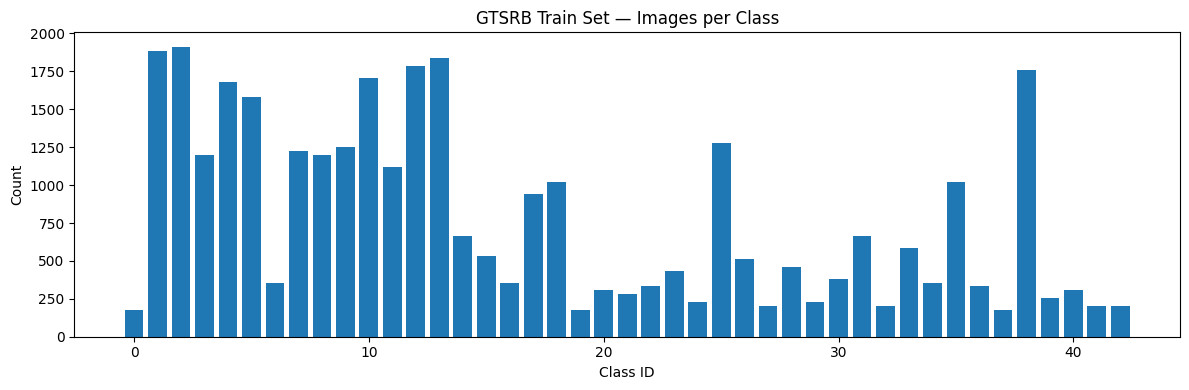

Label overview (first 10 classes):
class 00: train=179, val=31, test=60
class 01: train=1887, val=333, test=720
class 02: train=1912, val=338, test=750
class 03: train=1198, val=212, test=450
class 04: train=1683, val=297, test=660
class 05: train=1581, val=279, test=630
class 06: train=357, val=63, test=150
class 07: train=1224, val=216, test=450
class 08: train=1198, val=212, test=450
class 09: train=1249, val=221, test=480


In [23]:
# Simple bar chart (train distribution)
plt.figure(figsize=(12,4))
plt.bar(list(counts_train.keys()), list(counts_train.values()))
plt.title("GTSRB Train Set — Images per Class")
plt.xlabel("Class ID"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Print a compact label overview
print("Label overview (first 10 classes):")
for k in sorted(counts_train.keys())[:10]:
    print(f"class {k:02d}: train={counts_train[k]}, val={counts_val.get(k,0)}, test={counts_test.get(k,0)}")

In [24]:
# Train YOLOv8 Classification

model = YOLO("yolov8s-cls.pt")  # try yolov8m/l/x-cls.pt for higher accuracy

results = model.train(
    data=str(OUT),
    epochs=40,
    imgsz=224,
    batch=64,
    patience=10,
    lr0=0.003,
    mixup=0.2,
    cutmix=0.2,
    label_smoothing=0.1,
    workers=8
)


WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.186 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.2, data=/content/gtsrb_yolo, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

In [25]:
val_metrics = model.val(data=str(OUT))
print("Validation metrics:", val_metrics.results_dict)

Ultralytics 8.3.186 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,130,283 parameters, 0 gradients, 12.5 GFLOPs
train: /content/gtsrb_yolo/train... found 33327 images in 43 classes ✅ 
val: /content/gtsrb_yolo/val... found 5882 images in 43 classes ✅ 
test: /content/gtsrb_yolo/test... found 12630 images in 43 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 199.6±136.1 MB/s, size: 5.1 KB)
val: Scanning /content/gtsrb_yolo/val... 5882 images, 0 corrupt: 100% ━━━━━━━━━━━━ 5882/5882 2232458.3it/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 92/92 7.9it/s 11.6s
                   all          1          1
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
Validation metrics: {'metrics/accuracy_top1': 0.9998300075531006, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9999150037765503}


In [41]:
from ultralytics import YOLO
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# If 'model' isn't defined, load best.pt
try:
    _ = model.model
except Exception:
    import glob
    best = sorted(glob.glob("runs/classify/*/weights/best.pt"))[-1]
    model = YOLO(best)
    print("Loaded:", best)

In [42]:

# YOLO stores names as a dict {idx: class_name}
names_dict = model.names if isinstance(model.names, dict) else {i:n for i,n in enumerate(model.names)}
print("YOLO class index order (first 15):", [names_dict[i] for i in range(min(15, len(names_dict)))])


YOLO class index order (first 15): ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21']


In [43]:
def idx_to_true_id(idx):
    name = str(names_dict[idx])
    # For GTSRB we used numeric folder names, so 'name' should be '0'..'42'
    # If names are like '00000', still safe to int()
    return int(name)

In [44]:
y_pred_mapped = []
CHUNK, BATCH, IMGSZ = 800, 16, 224
test_root = "/content/gtsrb_yolo/test"

In [45]:
from pathlib import Path
def list_classes(p): return sorted([d for d in Path(p).iterdir() if d.is_dir()], key=lambda x:int(x.name))

# (Re)build ordered test set & y_true
test_files, y_true = [], []
cls_dirs = list_classes(test_root)
for d in cls_dirs:
    files = sorted([p for p in d.glob("*") if p.is_file()])
    test_files.extend(files)
    y_true.extend([int(d.name)] * len(files))

In [46]:
import gc, torch
for i in range(0, len(test_files), CHUNK):
    sub = [str(p) for p in test_files[i:i+CHUNK]]
    for r in model.predict(source=sub, imgsz=IMGSZ, batch=BATCH, save=False, stream=True, verbose=False):
        y_pred_mapped.append(idx_to_true_id(int(r.probs.top1)))
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    print(f"Predicted {min(i+CHUNK, len(test_files))}/{len(test_files)}")


Predicted 800/12630
Predicted 1600/12630
Predicted 2400/12630
Predicted 3200/12630
Predicted 4000/12630
Predicted 4800/12630
Predicted 5600/12630
Predicted 6400/12630
Predicted 7200/12630
Predicted 8000/12630
Predicted 8800/12630
Predicted 9600/12630
Predicted 10400/12630
Predicted 11200/12630
Predicted 12000/12630
Predicted 12630/12630


In [47]:
acc = accuracy_score(y_true, y_pred_mapped)
print(f"\n✅ Corrected Test Top-1 Accuracy: {acc*100:.2f}%\n")


✅ Corrected Test Top-1 Accuracy: 97.58%



In [48]:
print("Classification Report:")
print(classification_report(y_true, y_pred_mapped, digits=3))

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        60
           1      1.000     1.000     1.000       720
           2      0.996     0.999     0.997       750
           3      1.000     0.984     0.992       450
           4      0.998     0.995     0.997       660
           5      0.960     0.997     0.978       630
           6      1.000     1.000     1.000       150
           7      0.996     0.998     0.997       450
           8      0.998     0.953     0.975       450
           9      0.998     1.000     0.999       480
          10      1.000     0.998     0.999       660
          11      0.986     1.000     0.993       420
          12      1.000     1.000     1.000       690
          13      0.996     0.997     0.997       720
          14      1.000     1.000     1.000       270
          15      1.000     0.995     0.998       210
          16      1.000     1.000     1.000       150
    

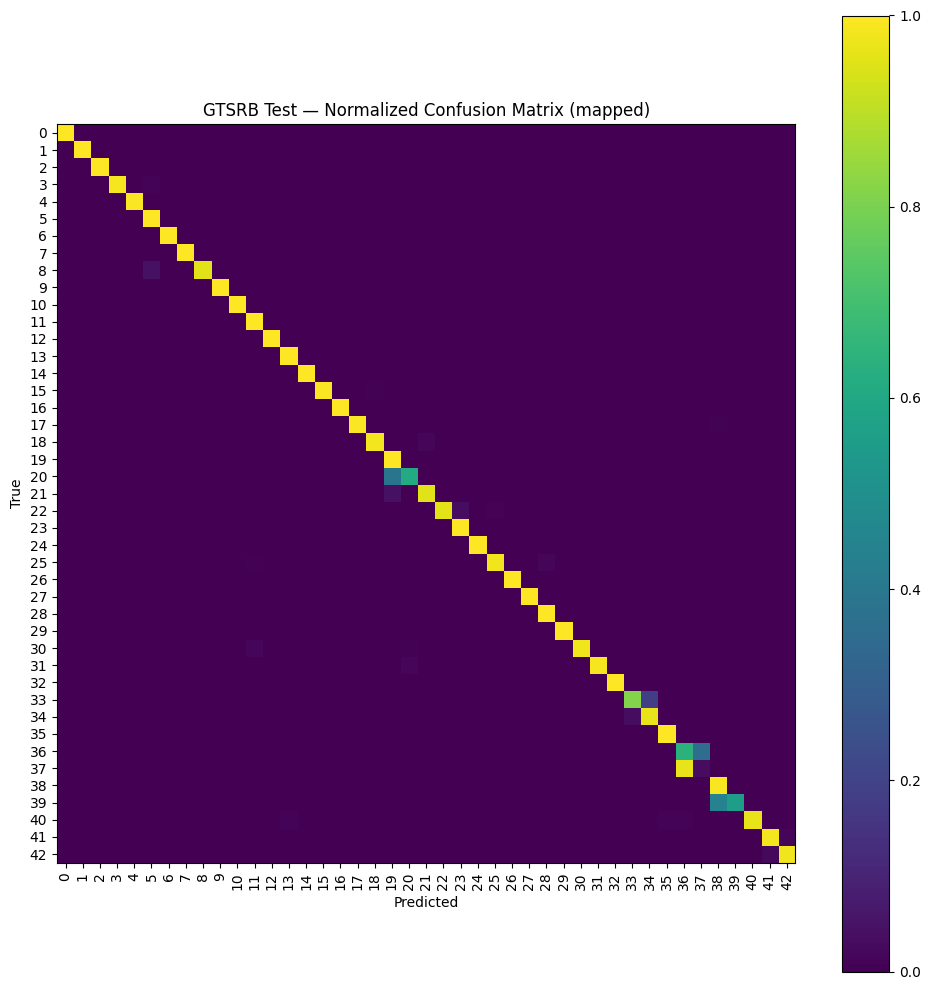

In [49]:
# Confusion matrix + per-class accuracy
num_classes = len(set(y_true))
cm = confusion_matrix(y_true, y_pred_mapped, labels=list(range(num_classes)))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)

plt.figure(figsize=(10,10))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("GTSRB Test — Normalized Confusion Matrix (mapped)"); plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, ticks, rotation=90); plt.yticks(ticks, ticks)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

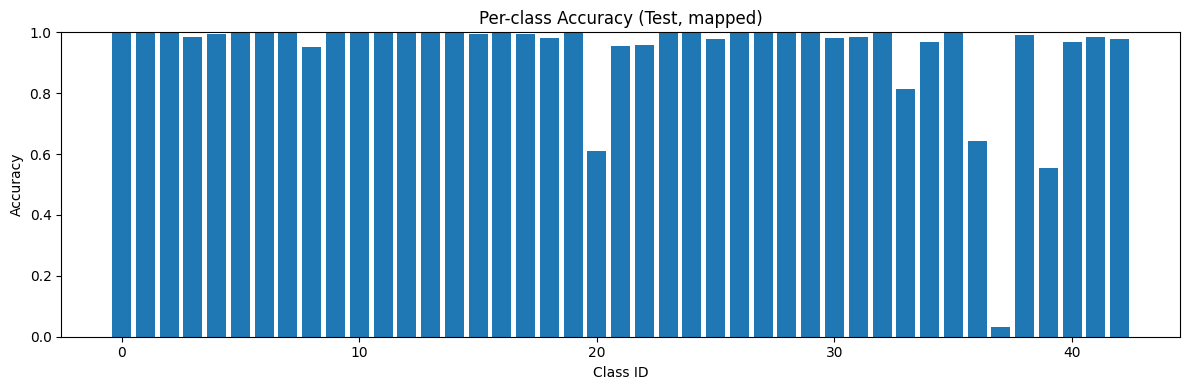

In [50]:

per_class_acc = cm.diagonal() / (cm.sum(axis=1) + 1e-9)
plt.figure(figsize=(12,4))
plt.bar(np.arange(num_classes), per_class_acc)
plt.title("Per-class Accuracy (Test, mapped)")
plt.xlabel("Class ID"); plt.ylabel("Accuracy"); plt.ylim(0, 1.0)
plt.tight_layout(); plt.show()

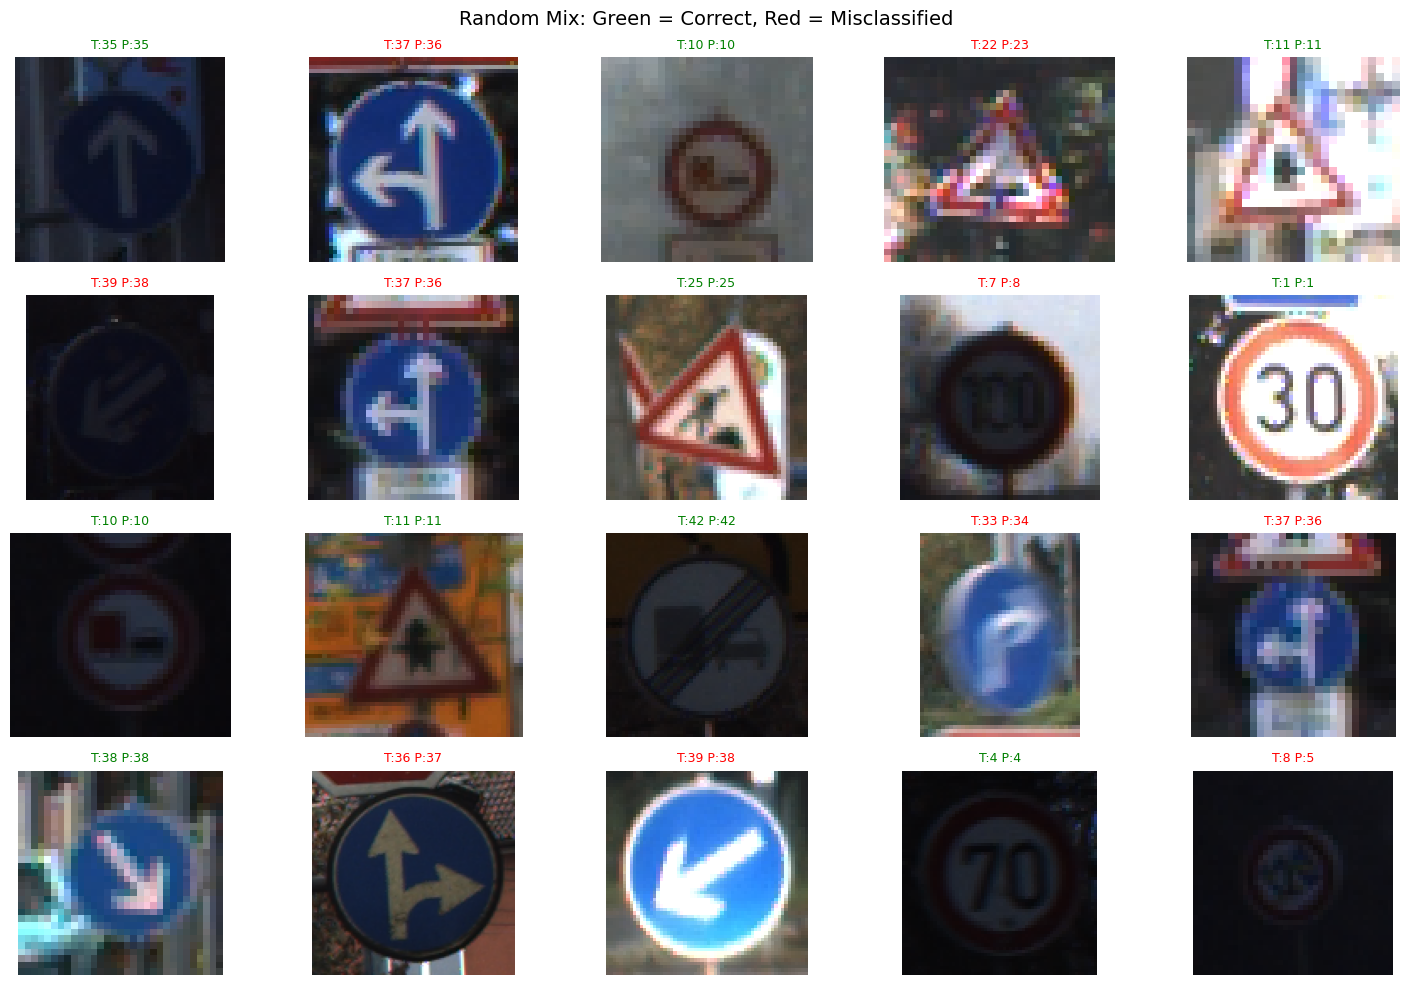

In [58]:
import random
import matplotlib.pyplot as plt

N = 20  # total to show
half = N // 2

# Indices of all correct and incorrect predictions
correct_idx = [i for i in range(len(y_true)) if y_true[i] == y_pred_mapped[i]]
wrong_idx   = [i for i in range(len(y_true)) if y_true[i] != y_pred_mapped[i]]

# Randomly sample
sample_correct = random.sample(correct_idx, min(half, len(correct_idx)))
sample_wrong   = random.sample(wrong_idx, min(half, len(wrong_idx)))
indices = sample_correct + sample_wrong
random.shuffle(indices)

# Plot
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices, 1):
    img_path = test_files[idx]
    true_label = y_true[idx]
    pred_label = y_pred_mapped[idx]

    img = plt.imread(img_path)

    plt.subplot(4, 5, i)
    plt.imshow(img)
    plt.axis("off")
    color = "green" if true_label == pred_label else "red"
    plt.title(f"T:{true_label} P:{pred_label}", color=color, fontsize=9)

plt.suptitle("Random Mix: Green = Correct, Red = Misclassified", fontsize=14)
plt.tight_layout()
plt.show()
